In [ ]:
import torch
from torch.utils.data import DataLoader

from aurora import Aurora

from bfm_finetune.aurora_mod import AuroraFlex
from bfm_finetune.plots import plot_eval
from bfm_finetune.dataloaders.geolifeclef_species.dataloader import GeoLifeCLEFSpeciesDataset
from bfm_finetune.dataloaders.dataloader_utils import custom_collate_fn
from bfm_finetune.utils import load_checkpoint, seed_everything

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

seed_everything(42)

Unknown platform ada. Assuming data is in the current directory
STORAGE_DIR: /home/thanasis.trantas/github_projects/bfm-finetune/data


In [4]:
base_model = Aurora(use_lora=False) # stabilise_level_agg=True
base_model.load_checkpoint("microsoft/aurora", "aurora-0.25-pretrained.ckpt") # strict=False
atmos_levels = (50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000)
base_model.to(device)

num_species = 500

model = AuroraFlex(base_model=base_model, in_channels=num_species, hidden_channels=160,
                    out_channels=num_species, atmos_levels=atmos_levels)
model.to(device)


val_dataset = GeoLifeCLEFSpeciesDataset(num_species=num_species, mode="val")
val_dataloader = DataLoader(
        val_dataset,
        batch_size=1,
        shuffle=False,
        collate_fn=custom_collate_fn,
        num_workers=1,
    )

params_to_optimize = model.parameters()
optimizer = torch.optim.AdamW(params_to_optimize, lr=1.0)

Initialized AuroraFlex Mod
files 1


Loaded checkpoint from /home/thanasis.trantas/github_projects/bfm-finetune/bfm_finetune/outputs/2025-04-03/13-11-19-0.04.loss/checkpoints/best_checkpoint.pth (epoch 901, loss: 0.0403)


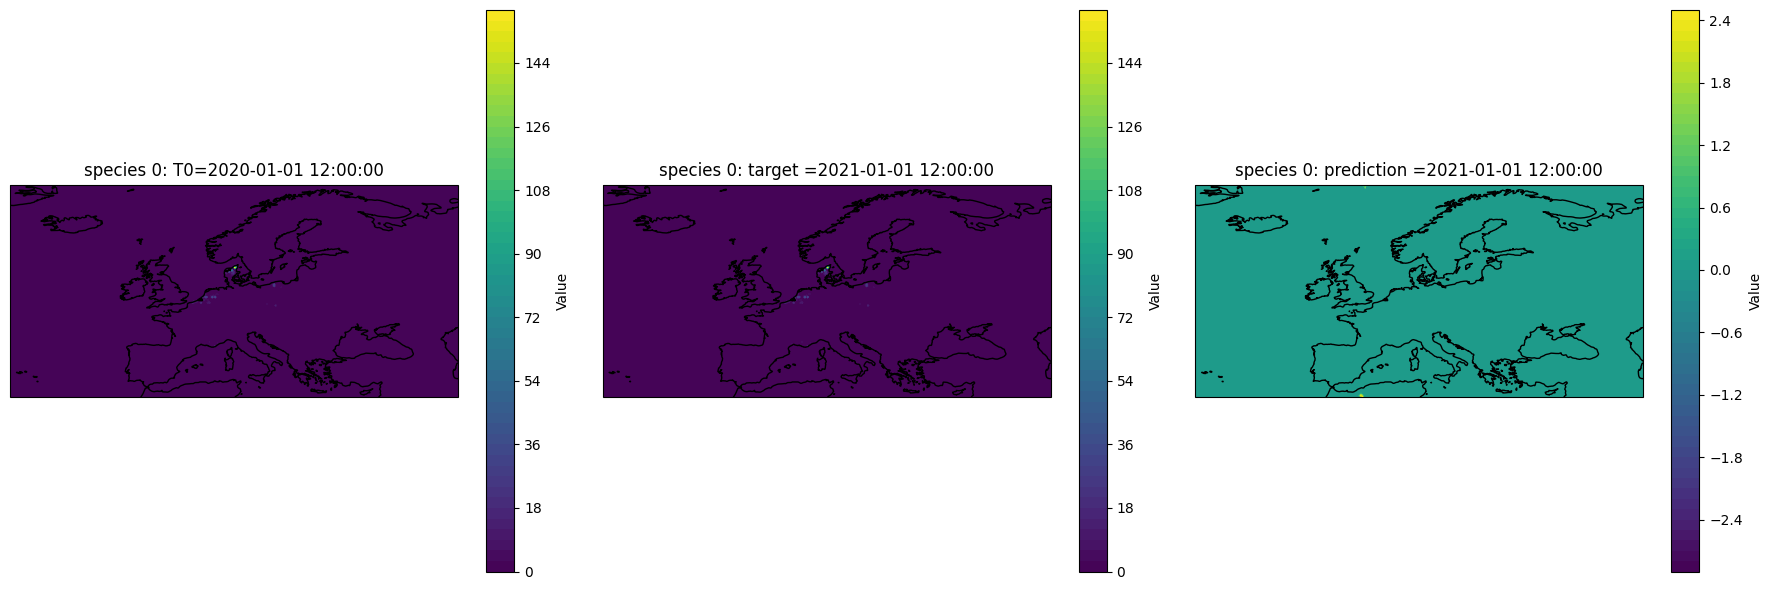

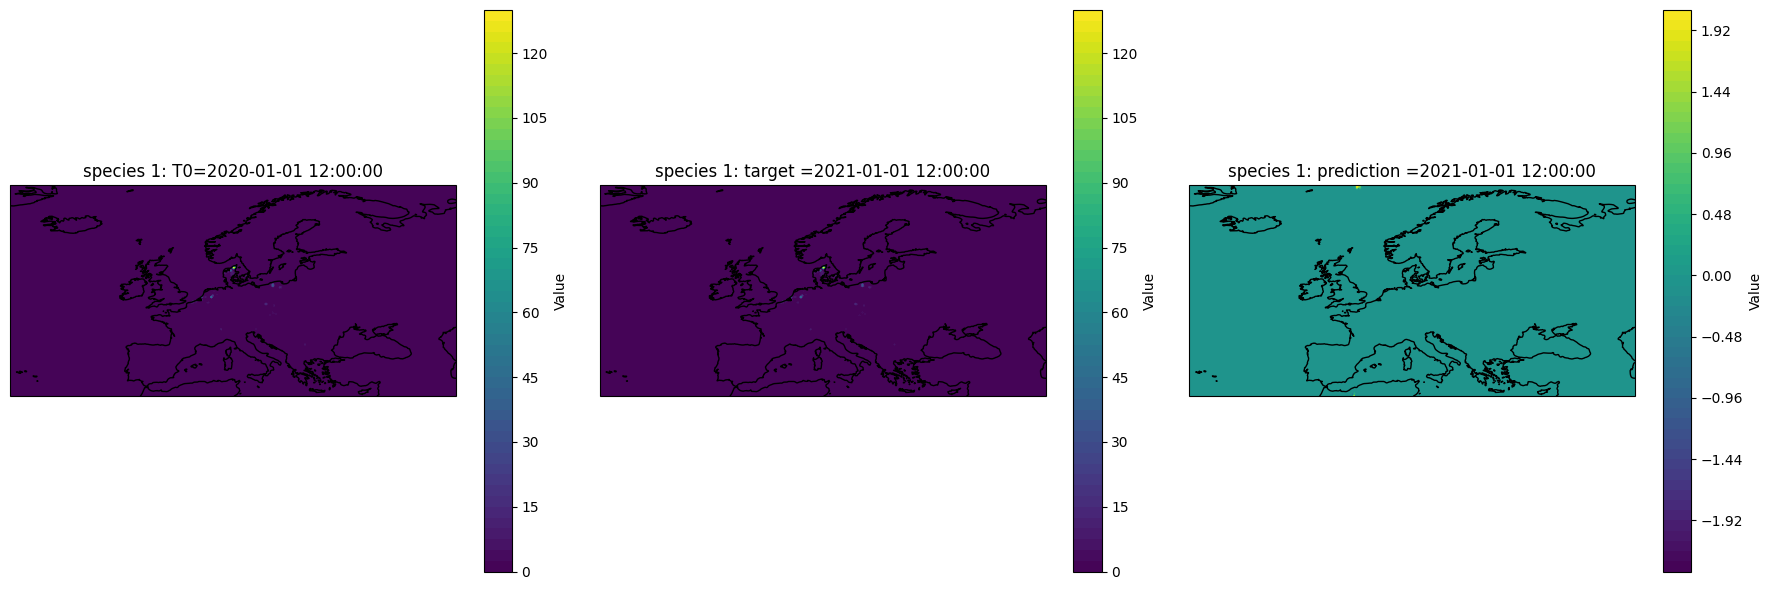

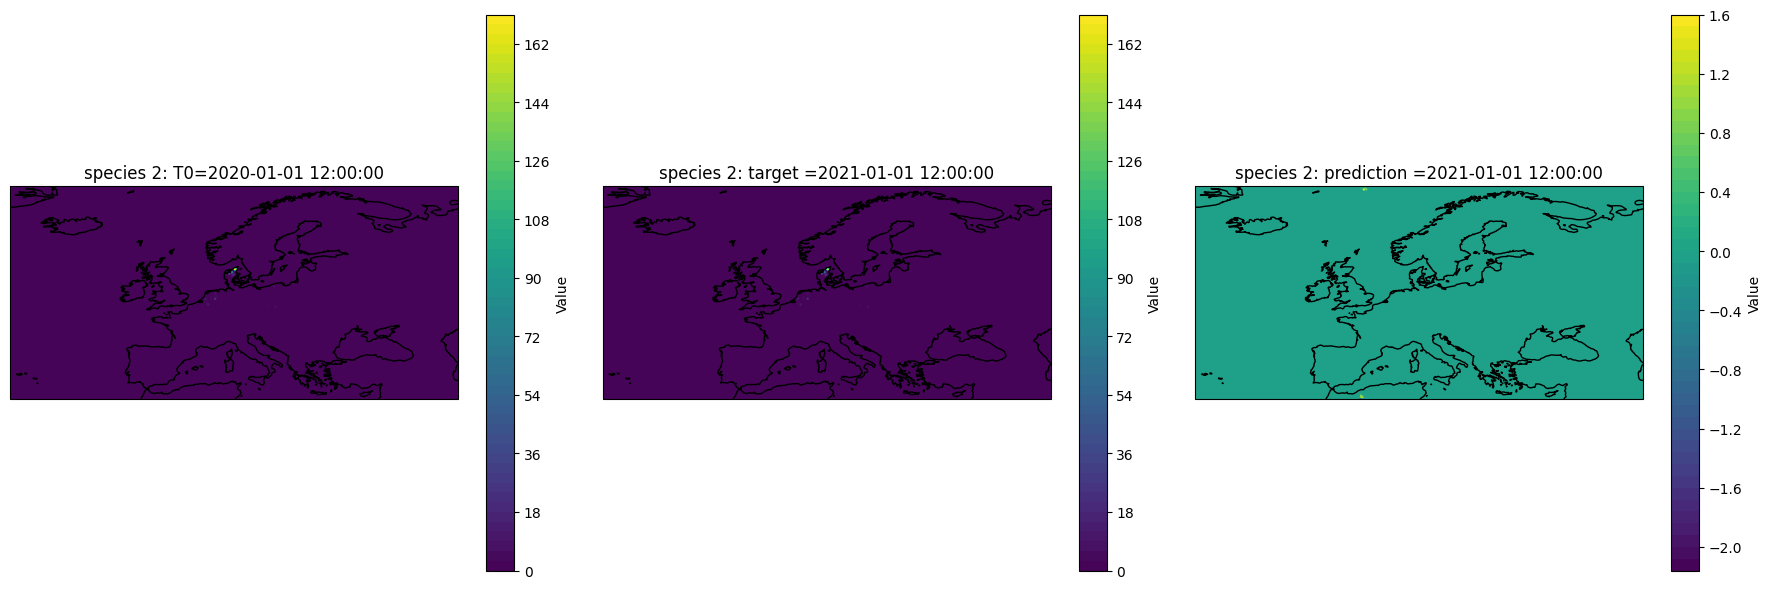

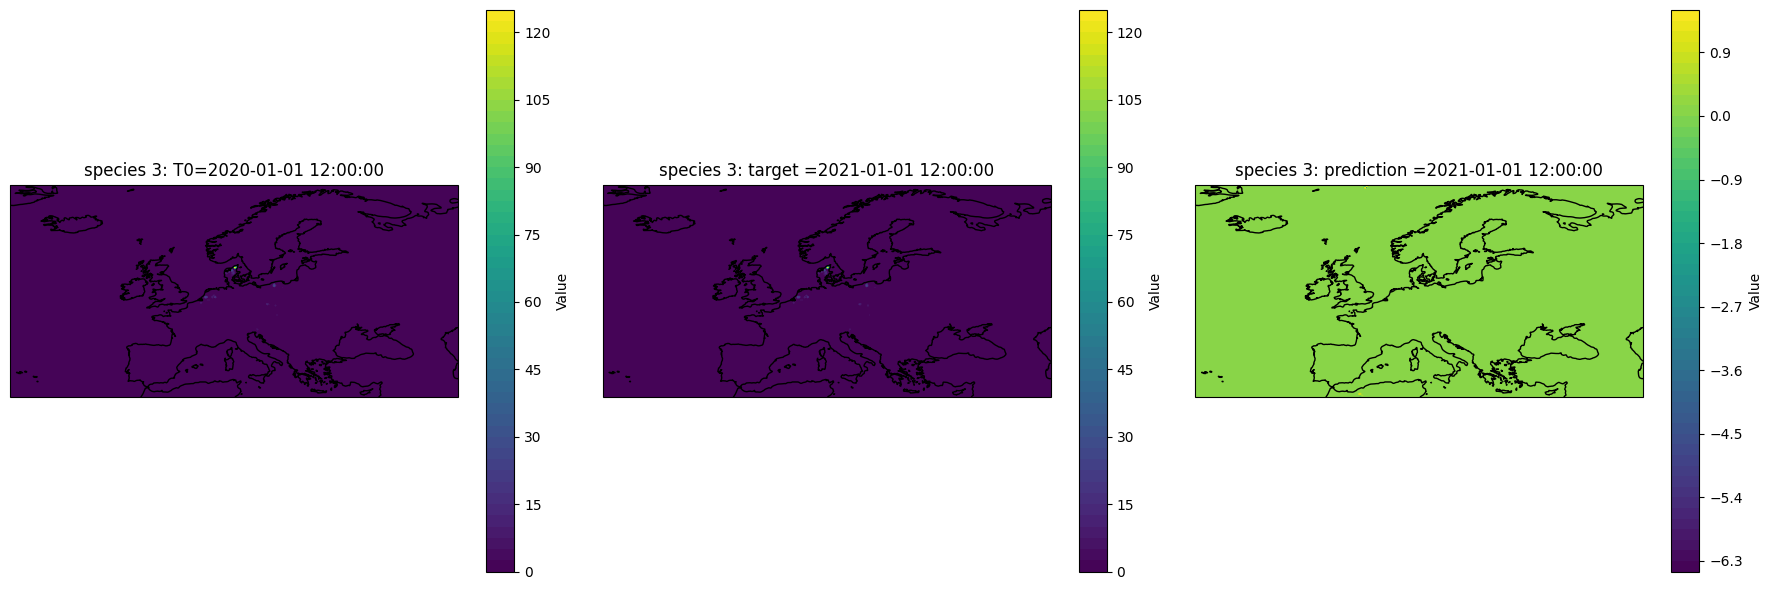

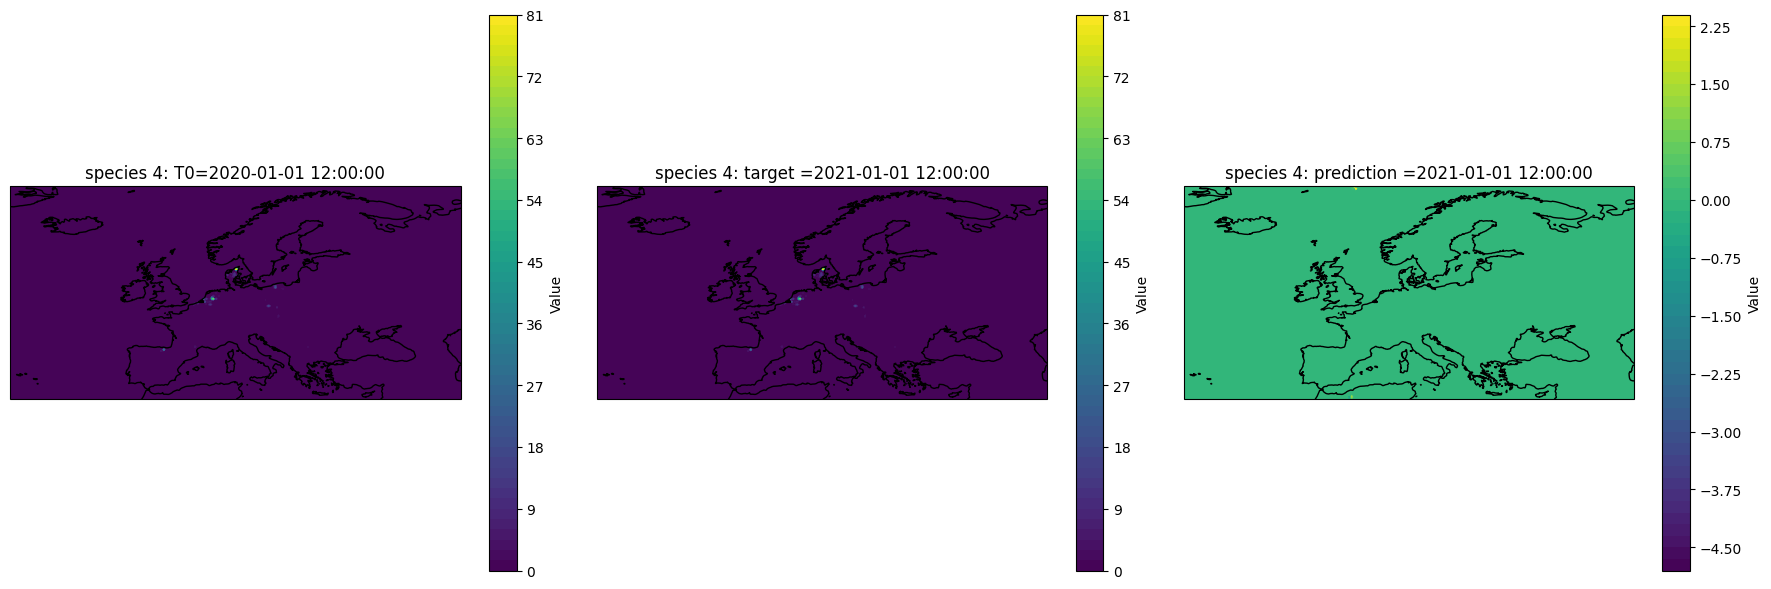

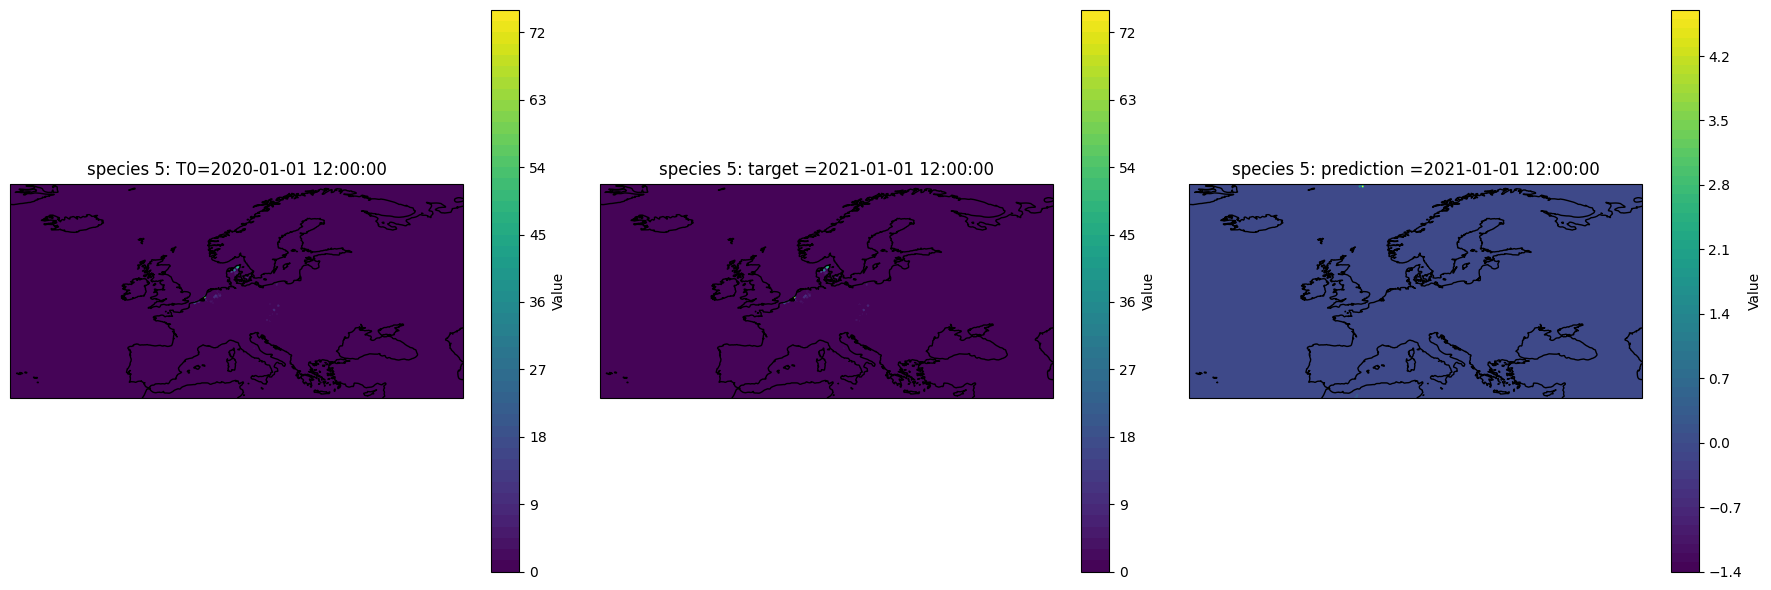

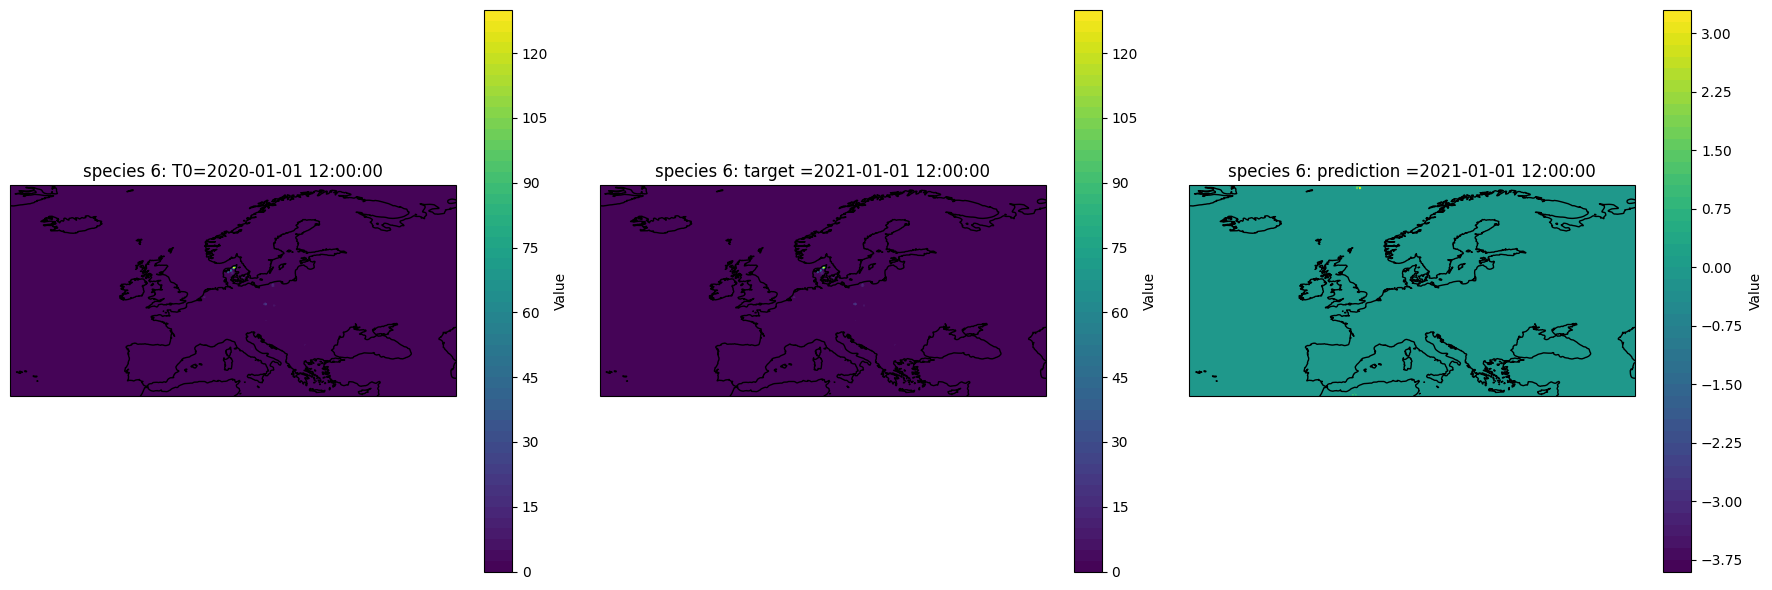

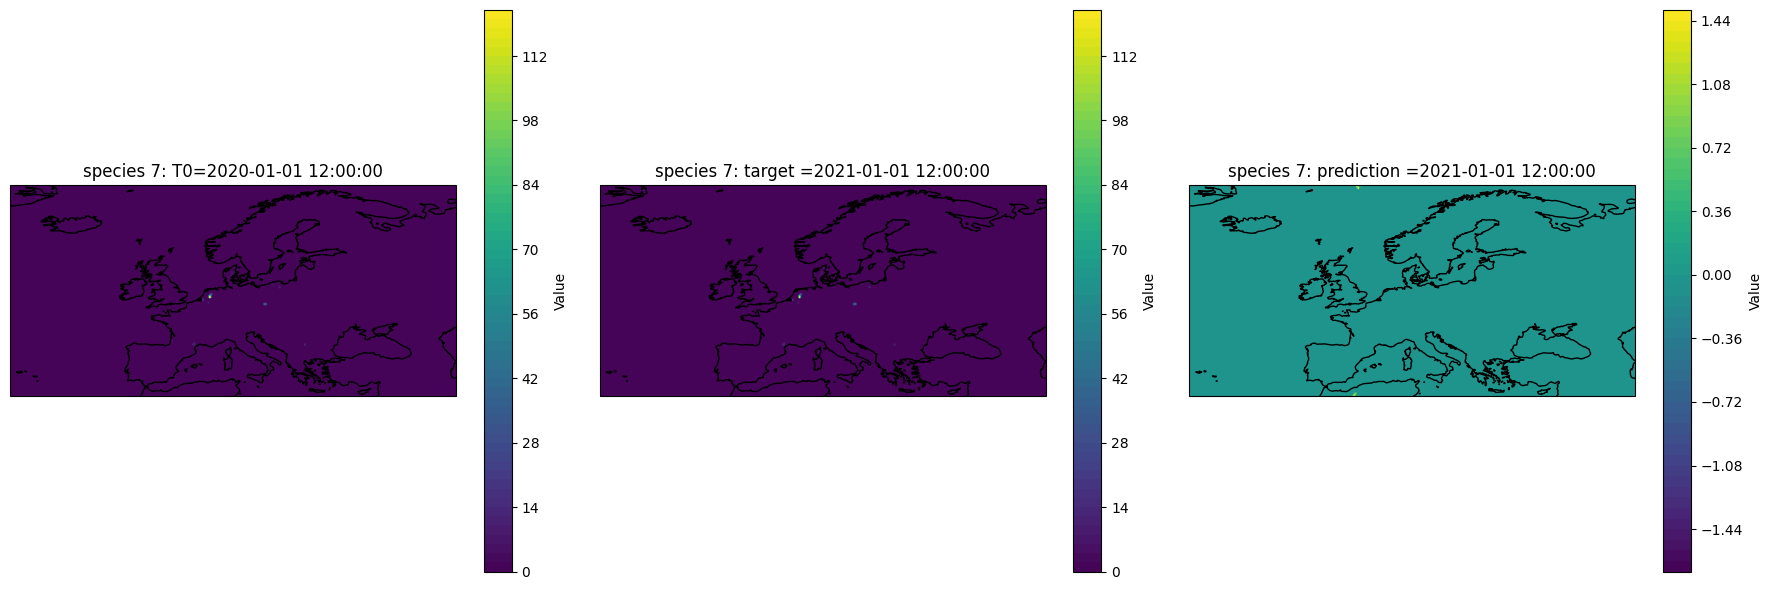

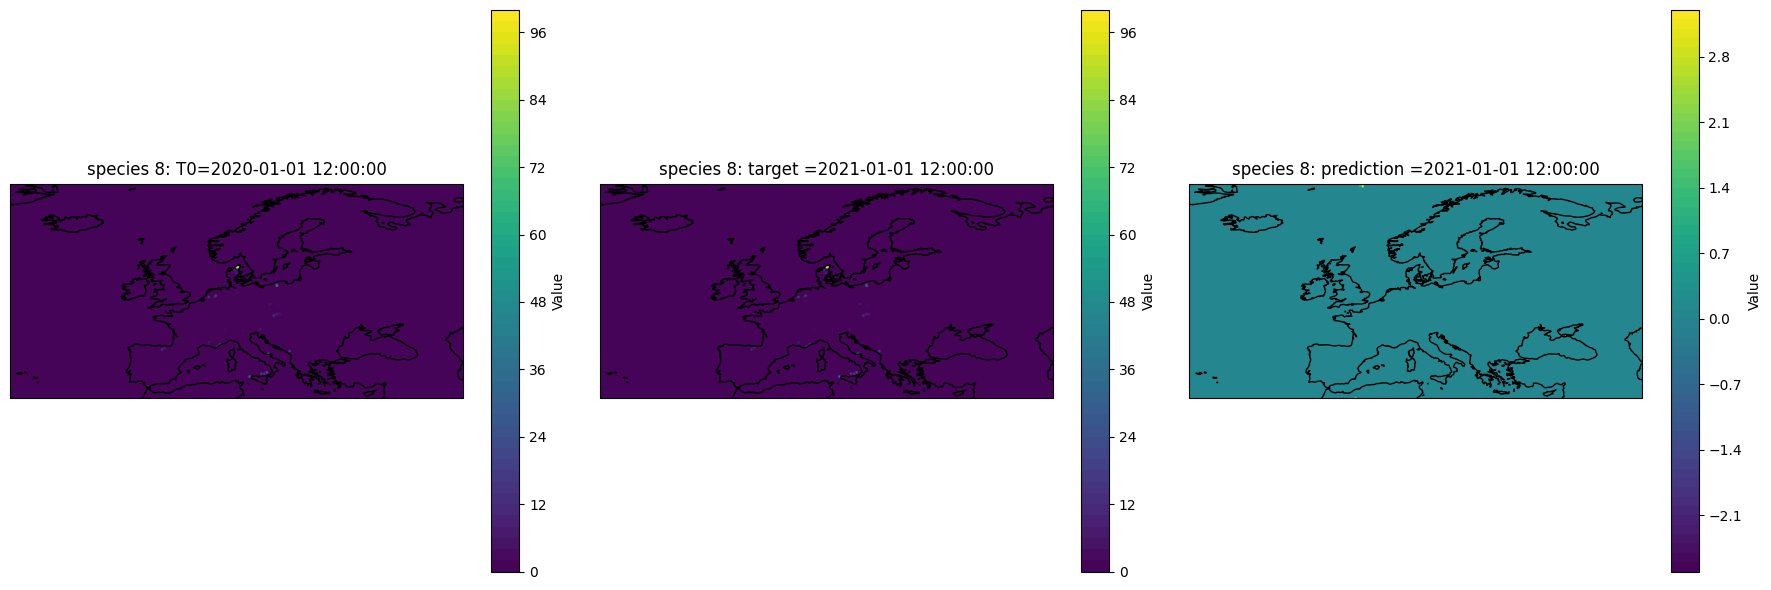

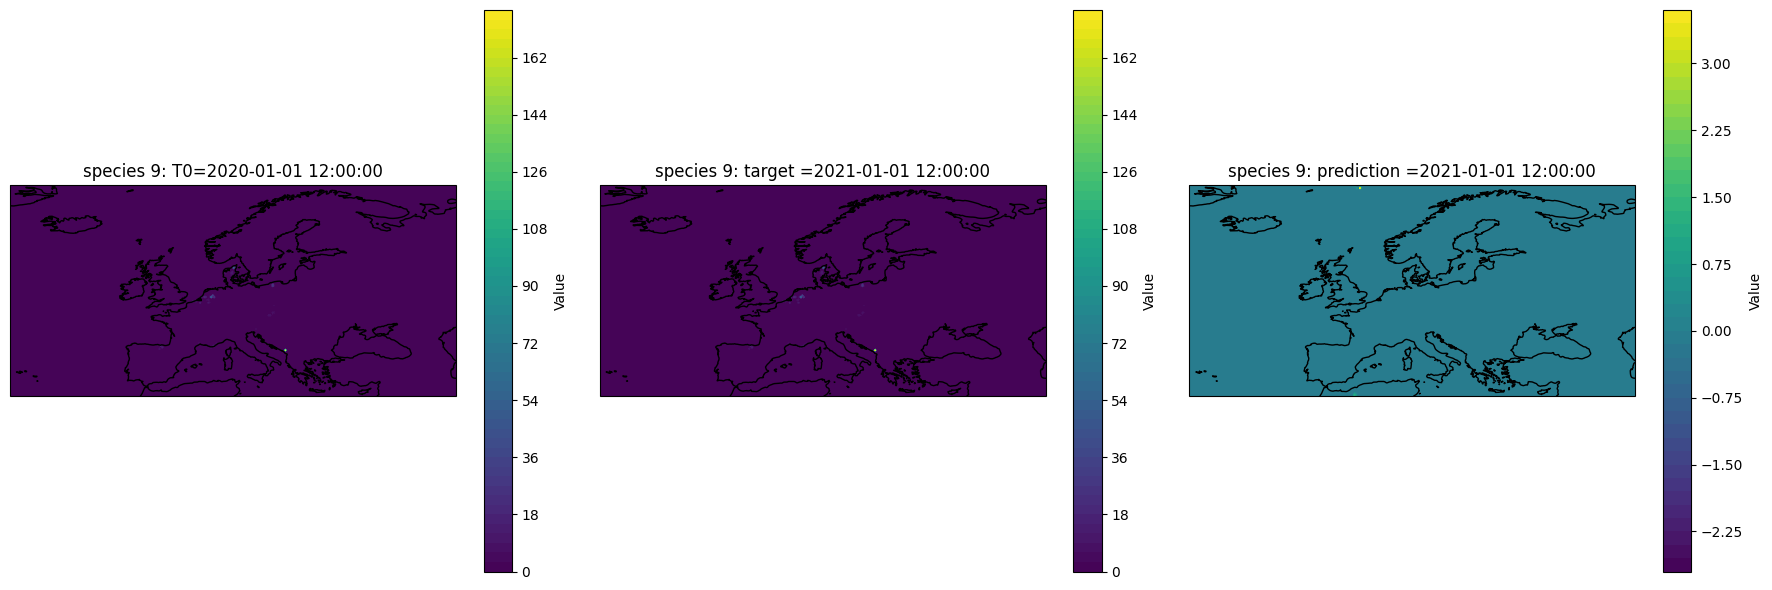

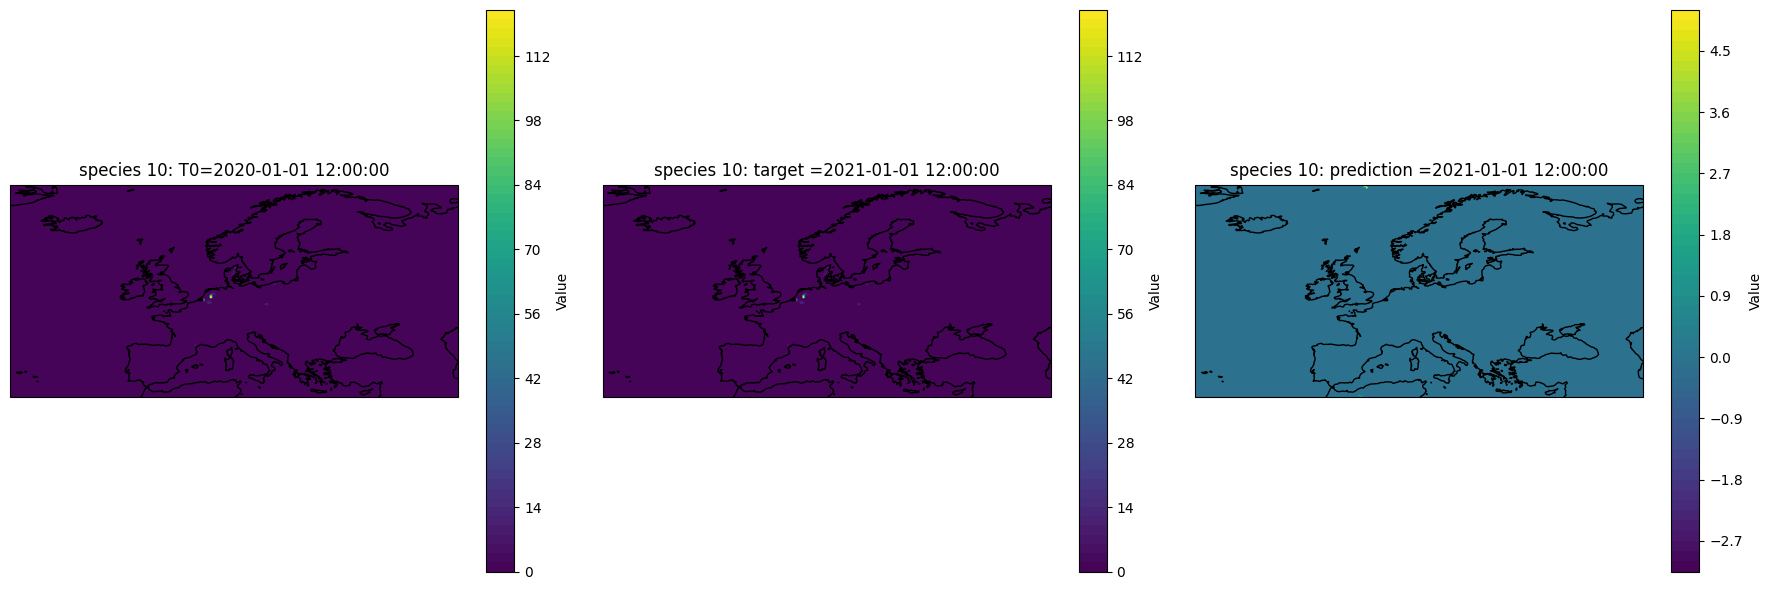

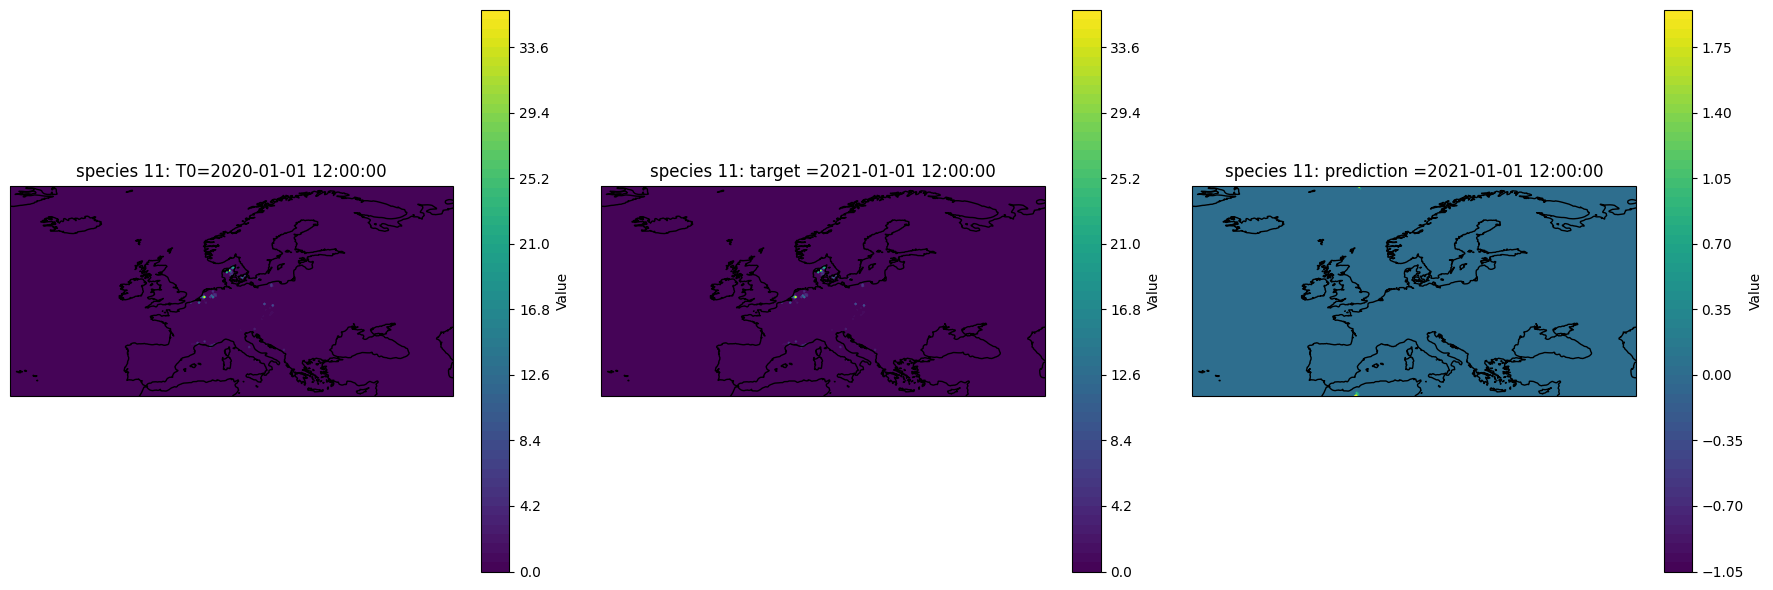

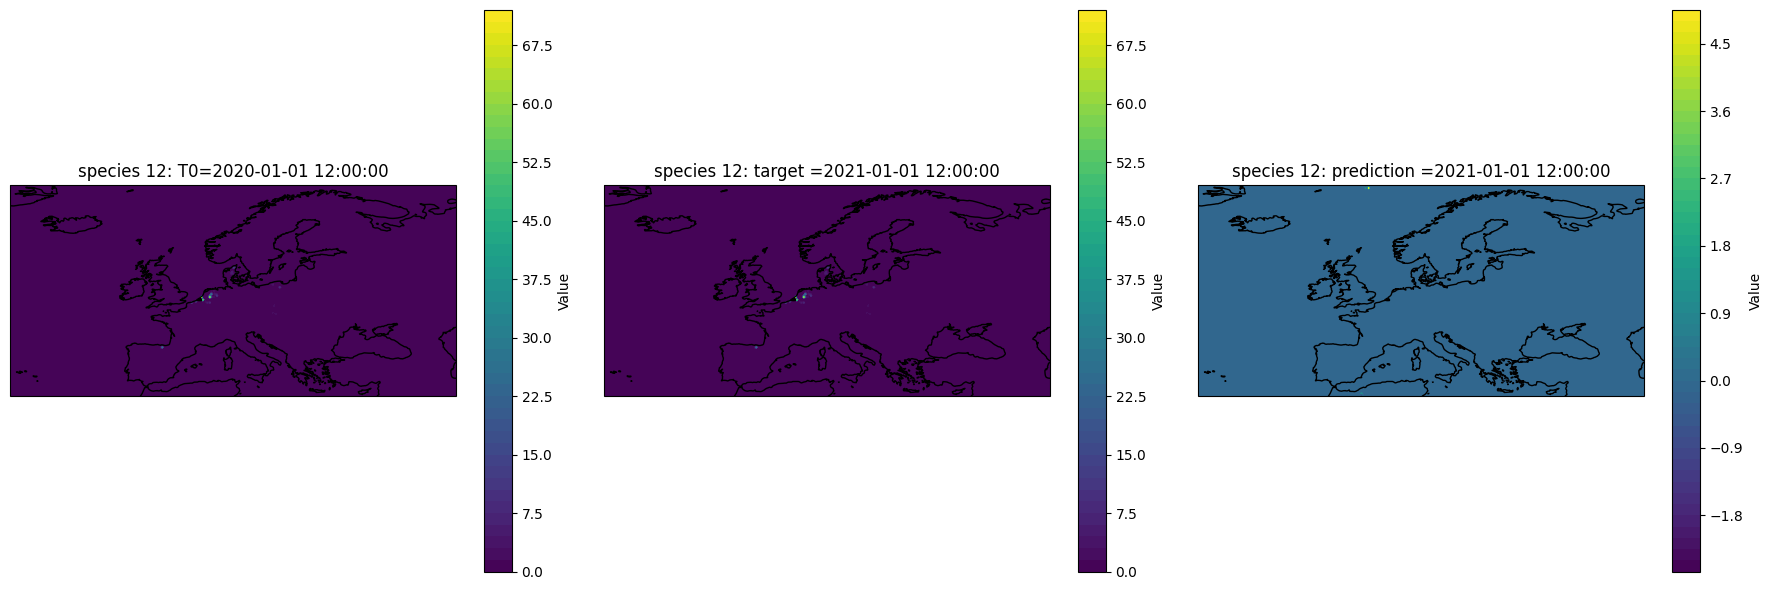

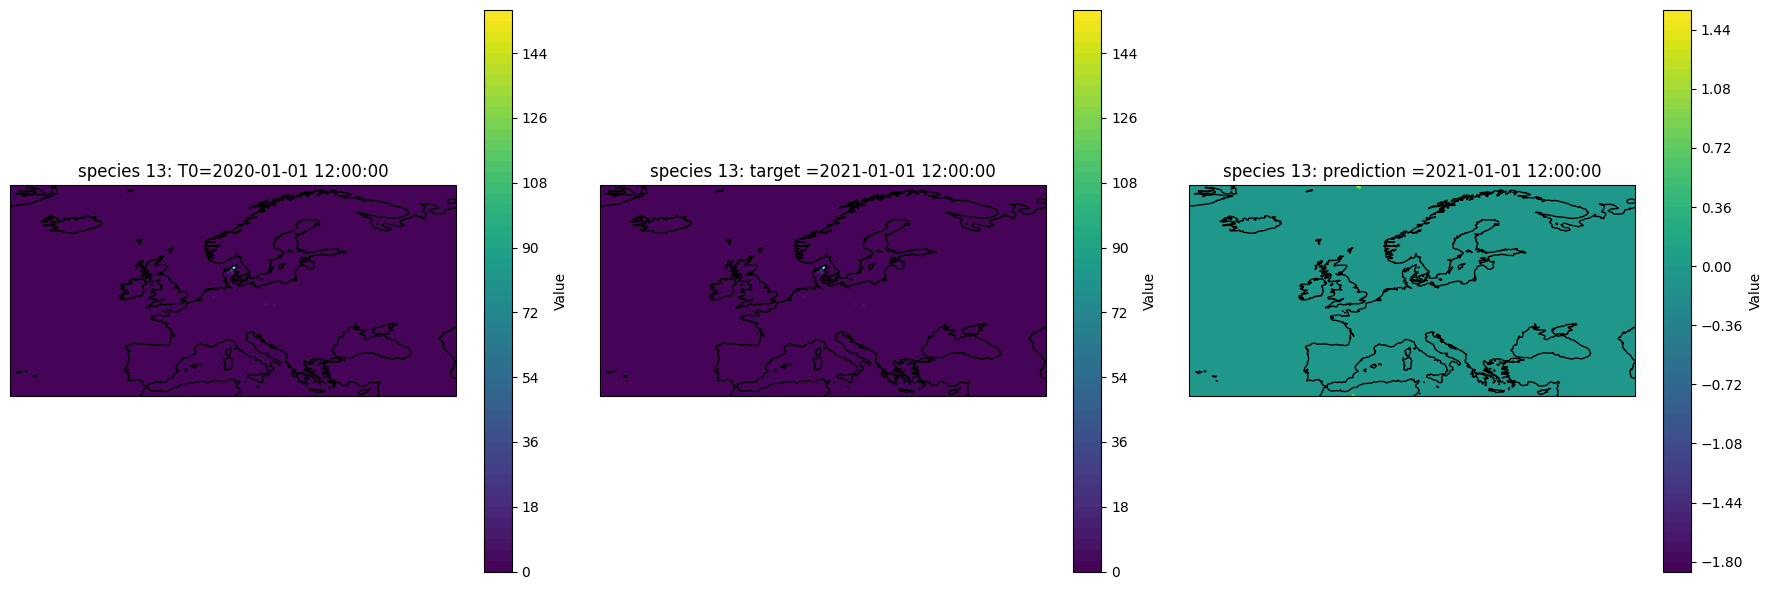

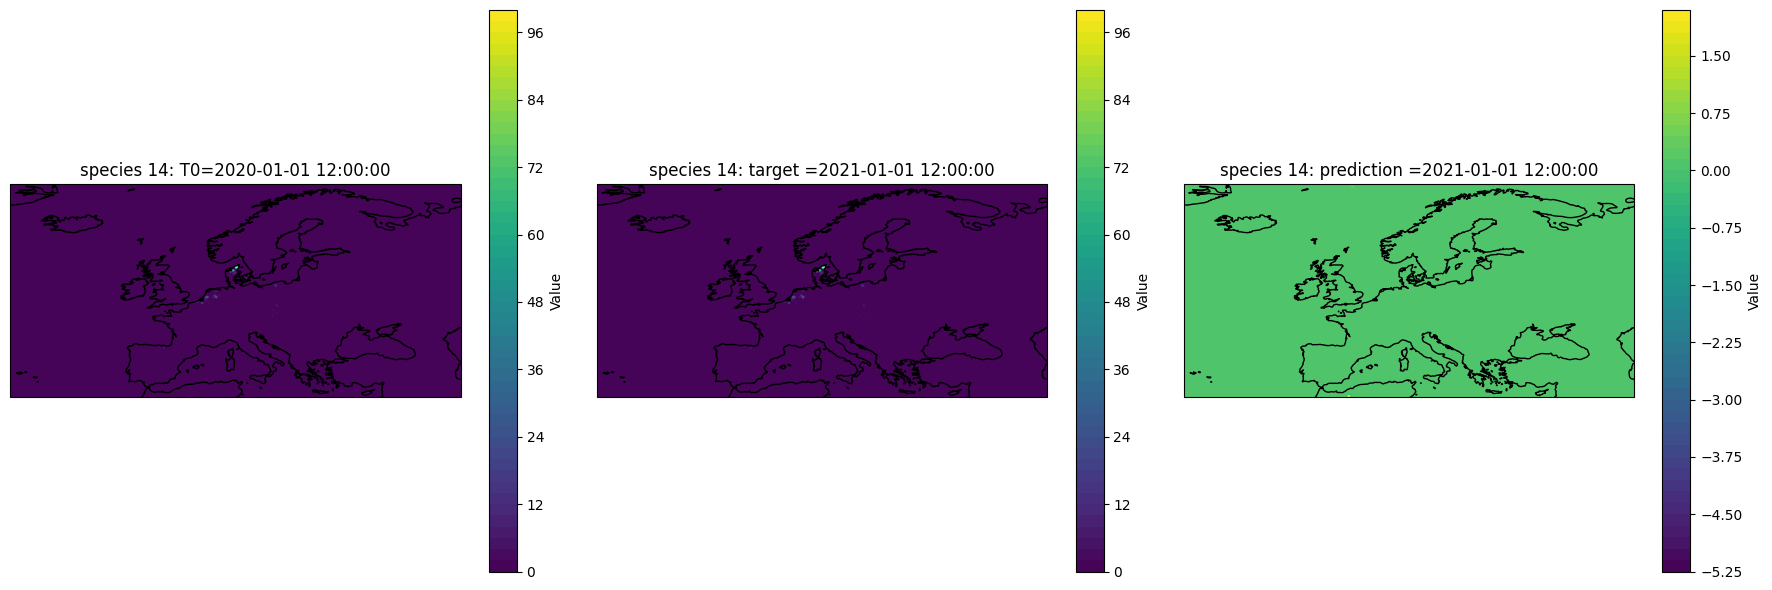

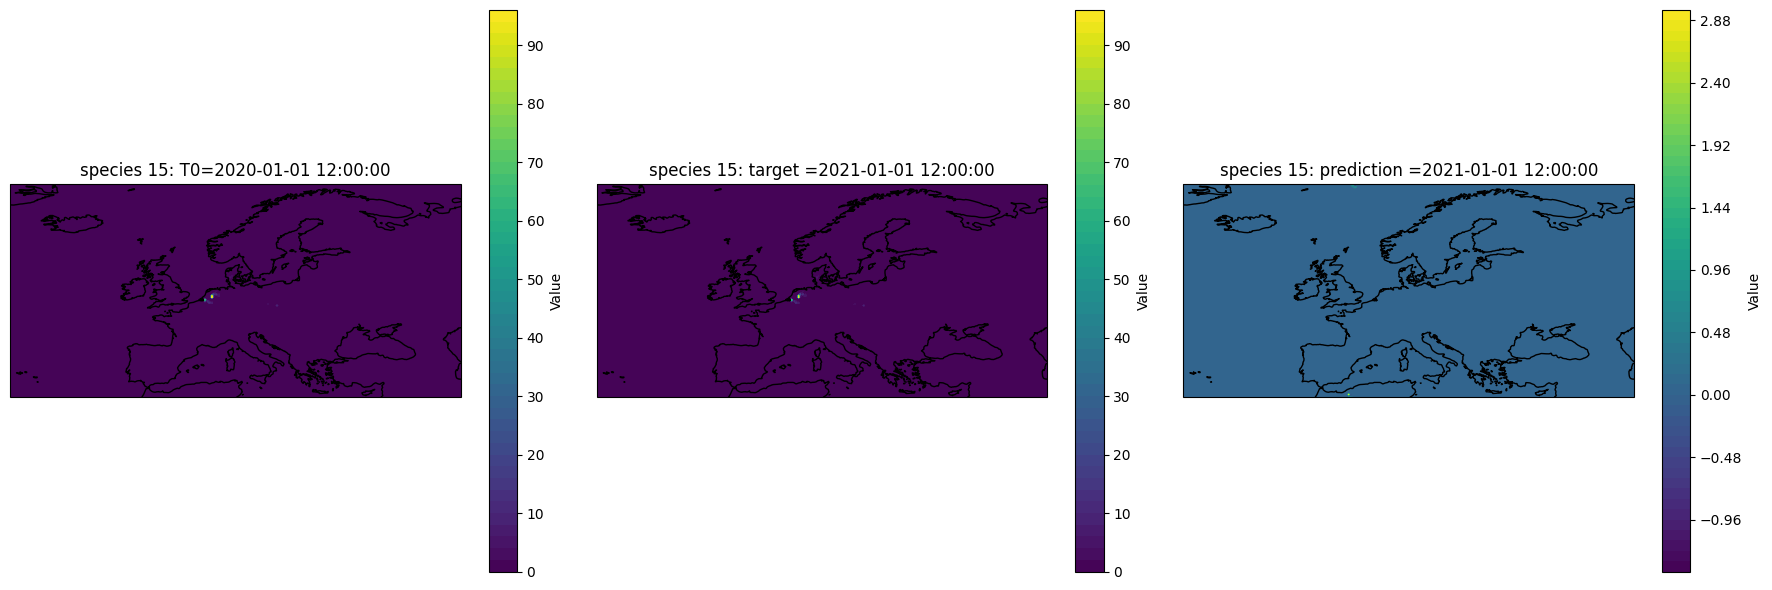

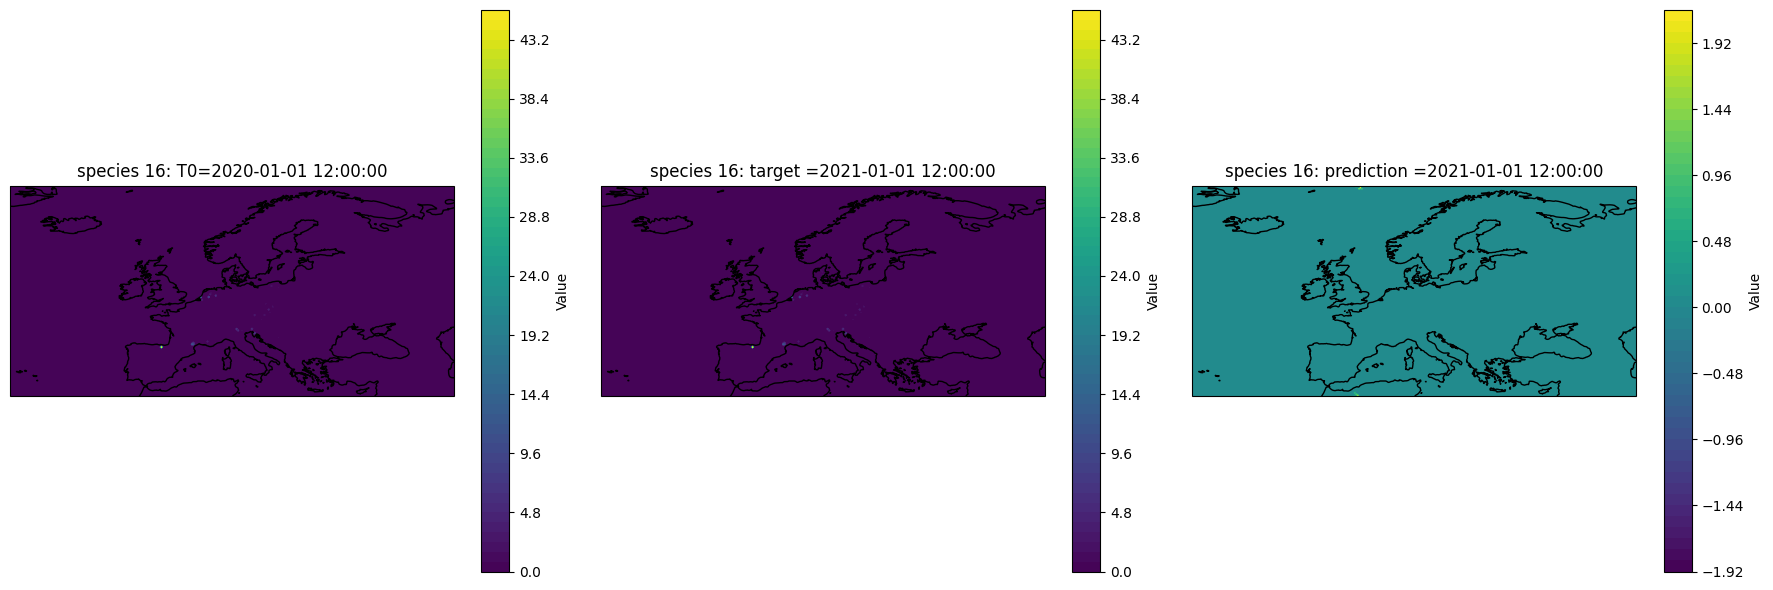

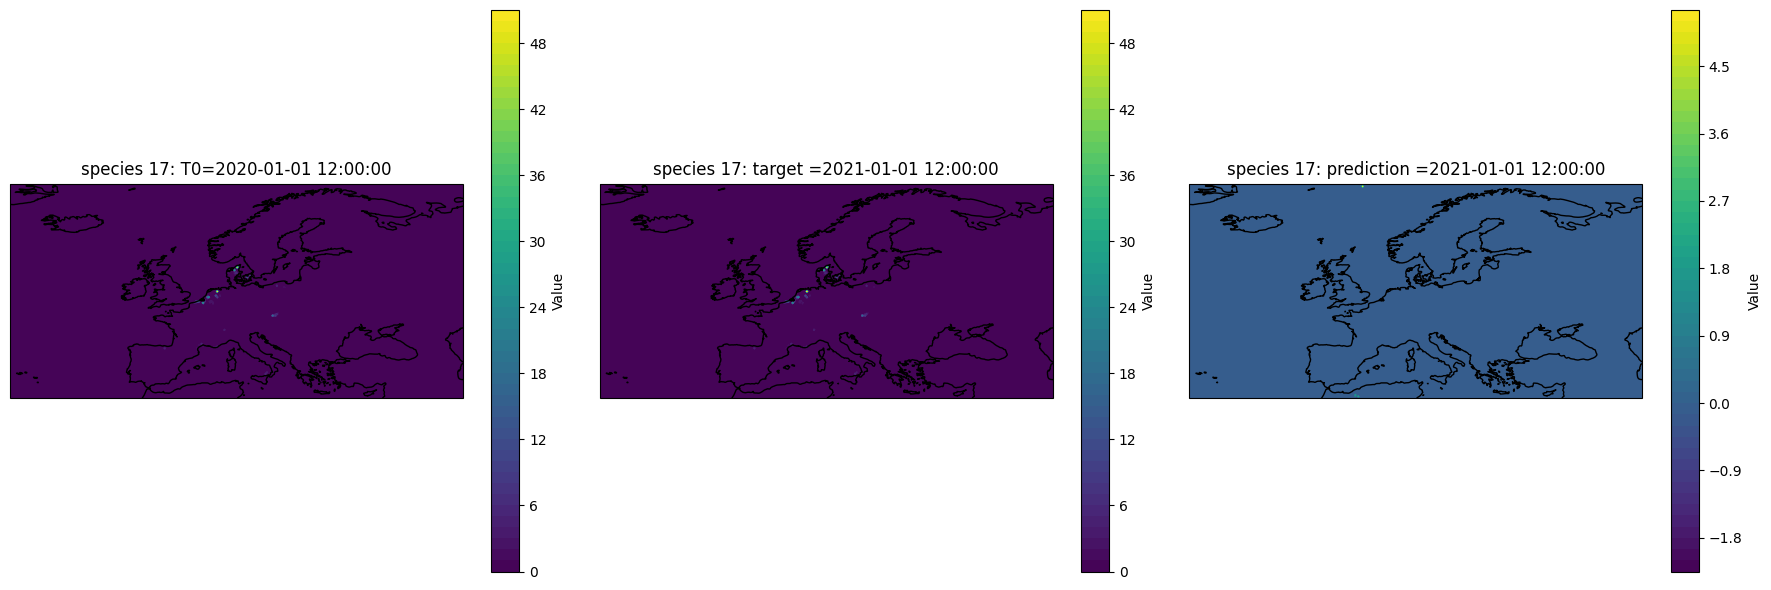

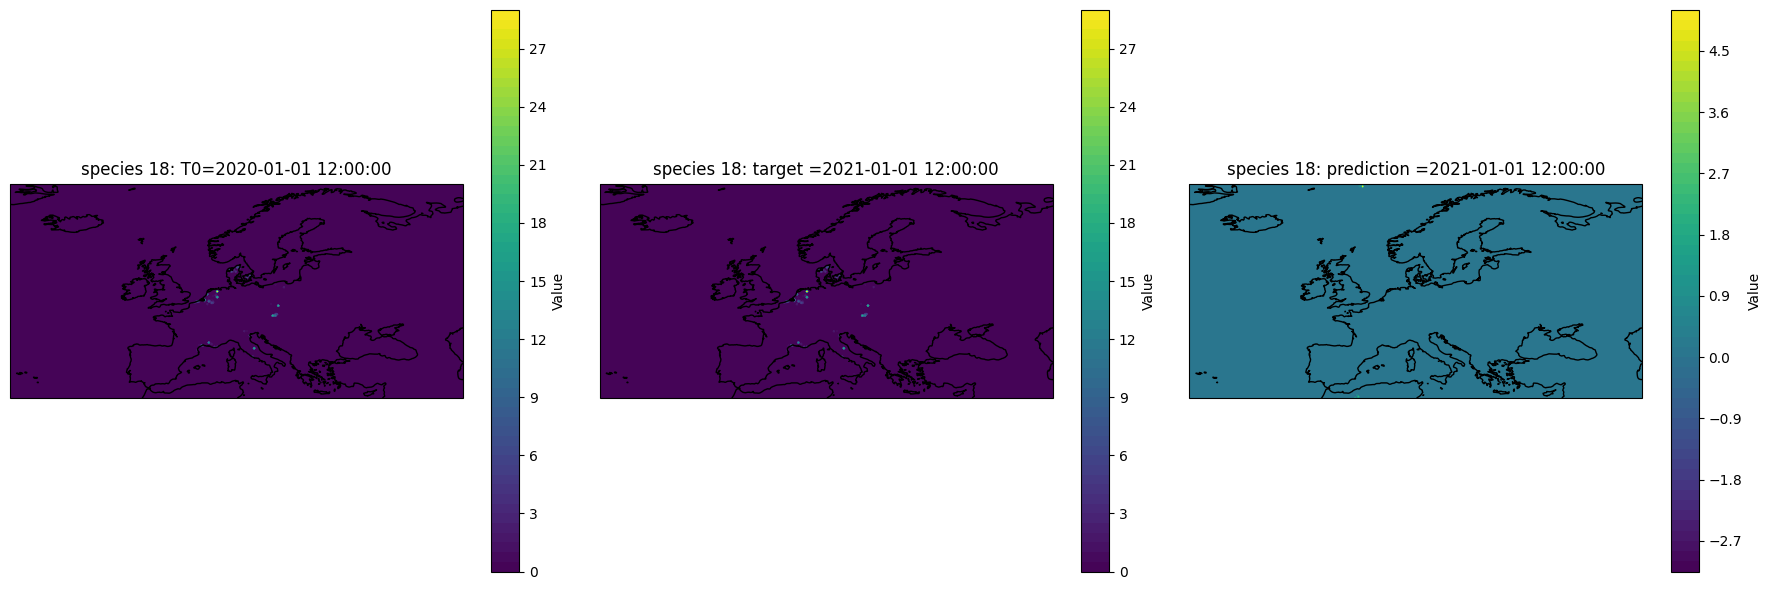

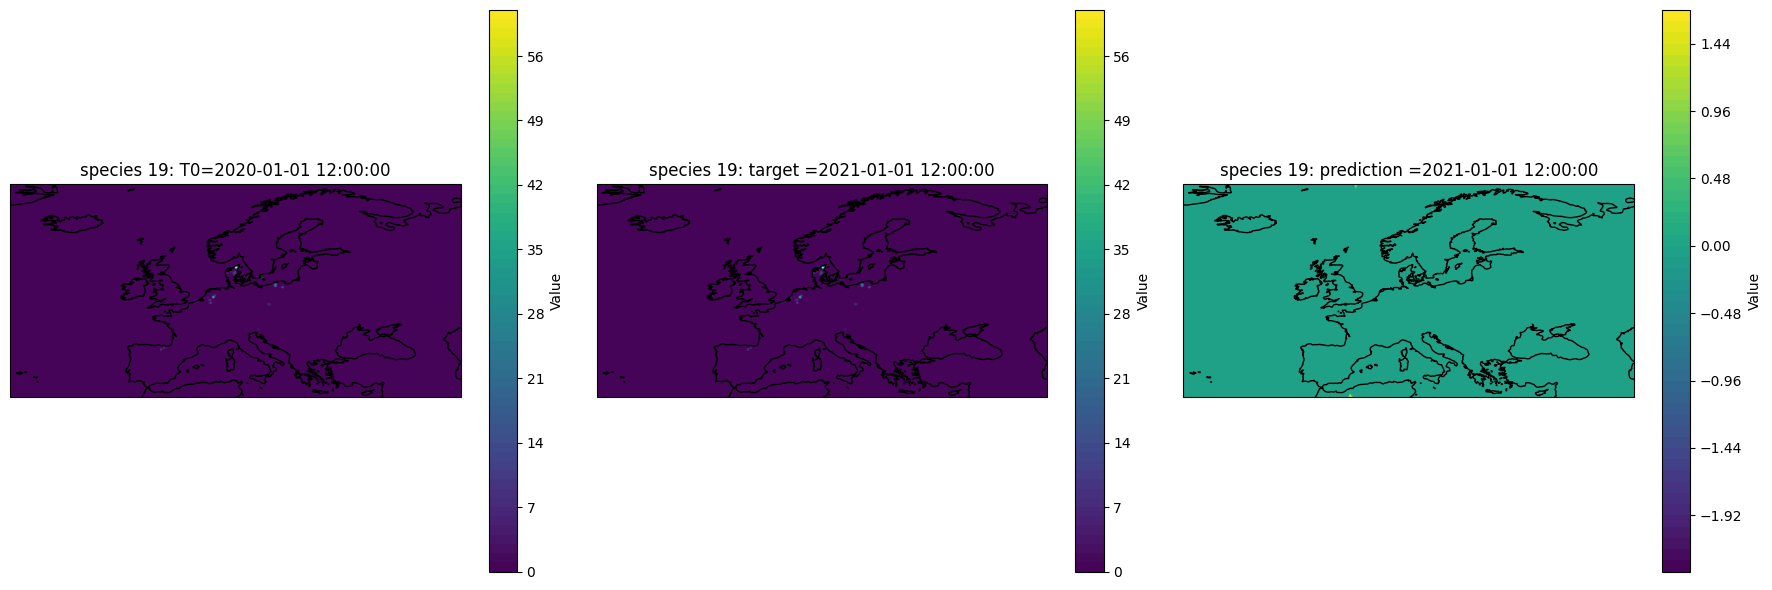

In [ ]:
PATH = "/home/thanasis.trantas/github_projects/bfm-finetune/bfm_finetune/outputs/2025-04-03/13-11-19-0.04.loss/checkpoints"
_, _ = load_checkpoint(model, optimizer, PATH)

for sample in val_dataloader:
    batch = sample["batch"].to(device)
    target = sample["target"]
    with torch.inference_mode():
        prediction = model.forward(batch)
    plot_eval(
        batch=batch,
        prediction_species=prediction,
        out_dir="plots_dir",
        save=False
    )